In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal, stats 
from scipy.optimize import curve_fit
from uncertainties import ufloat, unumpy

In [2]:
Eu = np.loadtxt('./data/Eu1.txt')
Cs = np.loadtxt('./data/Cs2.txt')
Ba = np.loadtxt('./data/Ba3.txt')
St = np.loadtxt('./data/Stone4.txt')

# Klasse die Spektroskopie analysiert

In [21]:
class makeSpek:
    """
    __init__(data, scale=1.):
    
    corPeak(newPeaks):
    
    setScale(newScale):
    
    plot(title='Bitte noch einen Title einfügen', pathToSave='Test'):
    
    plotSector(smin, smax, title="test", plotStyle=plt.plot, show = True):
    
    percentWidth(width, smin, smax, title="test", plotStyle=plt.plot):
    """
    def __init__(self, data, scale=1., bios=0.):
        """Search for Peaks in spektrum, create a x-Axis with scalefactor and save them in peak"""
        self.data = data
        self.scale = scale
        self.bios = bios
        self.hits = np.array([])
        self.xaxis = scale*np.linspace(0, len(data)-1, len(data))
        peaks = np.array(signal.find_peaks_cwt(vector=data, widths=np.arange(2,200), min_snr=8))
        self.peak = unumpy.uarray([self.xaxis.astype(float)[peaks],data[peaks]],[np.zeros(len(peaks)),np.zeros(len(peaks))])
    
    def corPeak(self, newPeaks):
        """Correct not right detected peaks by hand
        Parameters:
            newPeaks = ndarray
                    should include the new Peaks
        """
        self.peak = newPeaks
        if (self.peak.size>2):
            mask = np.argsort(self.peak[0,:])
            self.peak = np.array([self.peak[0,mask],self.peak[1,mask]])
            
    
    def setScale(self, newScale, newBios=0.):
        """Chance the default Scale"""
        self.scale = newScale
        self.bios = newBios
        self.xaxis = newScale*self.xaxis+self.bios
        self.peak[0] = newScale*self.peak[0]+self.bios
        
    def plot(self, pathToSave="Test",title="Bitte noch einen Title einfügen", scale='linear'):
        """Plot the Spektrum with the Maxima"""
        plt.plot(unumpy.nominal_values(unumpy.nominal_values(self.xaxis)), unumpy.nominal_values(self.data), label='Spektrum')
        plt.scatter(unumpy.nominal_values(self.peak[0]), unumpy.nominal_values(self.peak[1]), label='Fit Peaks')
        plt.title(r'Spektrum von $%s$' %title)
        plt.yscale(scale)
        plt.xlim(min(unumpy.nominal_values(self.xaxis))-10,max(unumpy.nominal_values(self.xaxis))+10)
        plt.ylim(-30,max(self.data)*1.1)
        plt.xlabel('Energie in keV')
        plt.ylabel('Counts')
        plt.legend(loc='best')
        plt.grid()
        #plt.savefig('./build/Spekt%s.pdf' % pathToSave)
        plt.show()
    
    def plotSector(self, smin, smax, title="test", plotStyle=plt.plot, show = True):
        """ make a plot of the define zone in plot style
        Parameters:
            smin = array_like shape=(1,) 
                    low limit of energie
            smax = array_like shape=(1,)
                    high limit of enegie
            title = string
                    string of Title
            plotType = methode(plt.plot, plt.scatter)
                    how should the data pictured
            show = boolean default:True
                    should the plot show in the function ? true/false
        """
        plt.title(r'%s' %title)
        self.arange = np.arange(int(smin/self.scale), int(smax/self.scale))
        plotStyle(self.xaxis[self.arange], self.data[self.arange],label='Detektiertes Signal')
        plt.xlim(min(self.xaxis[self.arange]), max(self.xaxis[self.arange]))
        plt.ylim(0,max(self.data[self.arange])*1.3)
        plt.xlabel('Energie in keV')
        plt.ylabel('Counts')
        plt.legend(loc='best')
        if (show == True):
            plt.show()
    
    def percentWidth(self, width, smin, smax, title="test", pathToSave="Test", plotStyle=plt.plot):
        """ calculate the width-worth plot the and give the width back
        Parameters:
            smin = array_like shape=(1,) 
                    low limit of energie
            smax = array_like shape=(1,)
                    high limit of enegie
            title = string
                    string of Title
            plotType = methode(plt.plot, plt.scatter)
                    how should the data pictured
        Returns:
            width = scalar
                    the width of the Peak
        """
        self.plotSector(smin, smax, title, plotStyle, show=False)
        wHeight = np.array(max(self.data[self.arange])/width)
        self.mPeak = self.xaxis[self.arange][self.data[self.arange] == max(self.data[self.arange])]
        mask = self.xaxis <= self.mPeak
        Schnittpunkt= np.array([])
        for i in [~mask, mask]:
            newData = self.data[i] 
            newXaxis = self.xaxis[i]
            dist = np.abs(self.data[i]-wHeight)
            x = newXaxis[dist.argsort()[:2]]
            y = newData[dist.argsort()[:2]]
            steigung = (y[1]-y[0])/(x[1]-x[0])
            f = np.poly1d([steigung,wHeight-y[0]])
            Schnittpunkt = np.append(Schnittpunkt, x[0]-np.roots(f))
            plt.plot((x[0]-np.roots(f), x[0]-np.roots(f)), (wHeight, 0), 'r--')
        print('Die', width, 'Wertsbreite beträgt : ',np.abs(np.diff(Schnittpunkt)))
        plt.plot((min(self.xaxis[self.arange]), max(self.xaxis[self.arange])), (wHeight, wHeight), 'k--')
        plt.savefig('./build/%sWertsbreite.pdf' % pathToSave)
        plt.show()
        return np.abs(np.diff(Schnittpunkt))
    
    def stdGaus(self, plot=False):
        """Fit a gaussian distritubution through the meassurments. Calculates the hits in one Event and the standard devitation
        Parameters:
            plot = Boolean
                information about the presentation of the Data. True = plot data with fit, False = calculate std of width of distribution
        Returns:
            ---
        """
        for a in unumpy.nominal_values(self.peak[0]):
            self.arange = np.arange(int(a/self.scale-10), int(a/self.scale+10))
            wHeight = max(self.data[self.arange])
            self.mPeak = self.xaxis[self.arange][self.data[self.arange] == max(self.data[self.arange])]
            def gaus(x,a,x0,sigma):
                return a*np.exp(-(x-x0)**2/(2*sigma**2))
            params, cov = curve_fit(gaus,self.xaxis[self.arange],self.data[self.arange], p0=(wHeight, self.mPeak, 1))
            std = np.sqrt(np.diag(cov))
            self.peak[unumpy.nominal_values(self.peak)==a]= ufloat(a, params[2])
            self.hits= np.append(self.hits, np.sqrt(2*np.pi)*ufloat(params[2],std[2])*ufloat(params[0], std[0])/self.scale)
            if (plot==True):
                print('Amplitude: ', params[0], '+-', std[0], 'Verschiebung: ', params[1], '+- ', std[1], 'sigma: ', params[2], '+- ', std[2])
                x = np.linspace(min(self.xaxis[self.arange]),max(self.xaxis[self.arange]), 50)
                print(self.data[self.arange])
                plt.plot(x, gaus(x, *params))
                plt.scatter(self.xaxis[self.arange], self.data[self.arange])
                plt.show()
            

# Eichung des Versuches

Search for the channels from the spectrum to calibrate the x-axis.

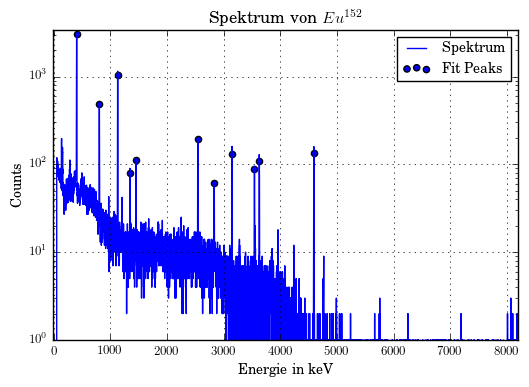

In [4]:
#Task a
EU = makeSpek(Eu)
EU.setScale(1)
mask = np.ones(len(EU.peak[0]), dtype=bool)
mask[-3:-1]=False
EU.corPeak(EU.peak[:,mask])
EU.plot('Eu','Eu^{152}', 'log')

Regression for scaling.

Steigung a:  0.306972+/-0.000027
y-Achsenabschnitt b:  -1.90+/-0.07
Kanäle:  [403.0+/-0 803.0+/-0 1128.0+/-0 1345.0+/-0 1452.0+/-0 2544.0+/-0 2832.0+/-0
 3147.0+/-0 3543.0+/-0 3629.0+/-0 4593.0+/-0]


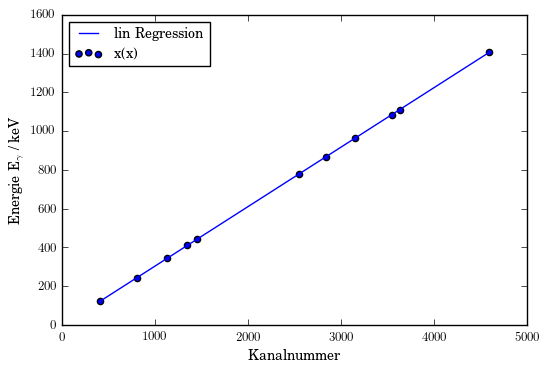

In [5]:
EGamma = np.array([121.7, 244.7, 344.3, 411.12, 443.9, 778.9, 867.37, 964.08, 1085.90, 1112.10, 1408.00])
def linReg(x, a, b):
    return a*x + b
params, cov = curve_fit(linReg, unumpy.nominal_values(EU.peak[0,:]), EGamma)
std = np.sqrt(np.diag(cov))
caliBios = ufloat(params[1], std[1])
caliAscent = ufloat(params[0], std[0])
scaleing = params[0]
print('Steigung a: ',caliAscent)
print('y-Achsenabschnitt b: ', caliBios)
print('Kanäle: ', EU.peak[0])
plt.scatter(unumpy.nominal_values(EU.peak[0,:]), EGamma, label=r'x(x)')
plt.plot(unumpy.nominal_values(EU.peak[0,:]), linReg(unumpy.nominal_values(EU.peak[0,:]), *params), label='lin Regression')
plt.xlabel('Kanalnummer')
plt.ylabel(r'Energie E$_{\gamma}$ / keV')
plt.legend(loc='best')
plt.savefig('./build/CsReg.pdf')
plt.show()

Spectrum with calibrate axis.

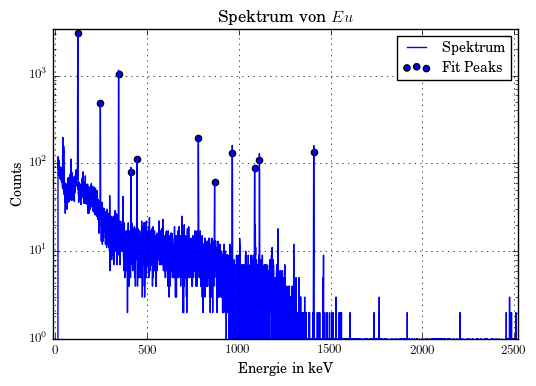

[121.81430939577832+/-0.07208170103984483
 244.6030751750207+/-0.07446328825580102
 344.3689473706552+/-0.07745206943014046
 410.98185280589416+/-0.07991918004587445
 443.8278476518415+/-0.08126253455525616
 779.0411782291733+/-0.09879588263047567
 867.4490895902278+/-0.10431103106717957
 964.1452426413812+/-0.11064987115459707
 1085.7061207628312+/-0.11899614356620641
 1112.1057054053683+/-0.12085661998682515
 1408.0266309333426+/-0.1426207518445628]


In [6]:
EU.setScale(caliAscent, caliBios)
EU.plot('Eu^{152}','Eu','log')
print(EU.peak[0])

In [7]:
from uncertainties import unumpy as un
aktEu = un.uarray(4130, 60)
halbEu = un.uarray(4943, 5) # in Tagen
tDiff = 365*16+98 # in Tagen
print("Zeitdifferenz der Vermussung bei Euchung und versuchsentnahme: ", tDiff, " Tage")
def aktNachTagen(t, akt, halbWz):
    return akt*un.exp(-(np.log(2)/halbWz)*t)
AktEu = aktNachTagen(tDiff, aktEu, halbEu)
print('Aktivität: ', AktEu)
distance = ufloat(0.088,0.0002)
Raumwinkel = 2.*np.pi*(1-distance/(np.sqrt(distance.nominal_value**2+0.0225**2)) )# strenggenommen darf die näherung nur für a > 10cm benutzt werden
print("Raumwinkel: ", Raumwinkel)
print("Noch einmal Gaußsche Fehlerfortpfalnzung per Hand durchführen !!!!!!!!!!!!!!")

Zeitdifferenz der Vermussung bei Euchung und versuchsentnahme:  5938  Tage
Aktivität:  1796+/-26
Raumwinkel:  0.196+/-0.014
Noch einmal Gaußsche Fehlerfortpfalnzung per Hand durchführen !!!!!!!!!!!!!!


# Effizienz

Effizienz [0.07188060379908677+/-0.005184920258813045
 0.04454500160583282+/-0.0032131377457610697
 0.04044715512743364+/-0.0029175502562243235
 0.04069489188811617+/-0.0029354201026283097
 0.016851989075761284+/-0.0012155743683572241
 0.01635927733002289+/-0.0011800338890455217
 0.010183677691179756+/-0.0007345730834121236
 0.009717757796812054+/-0.0007009651645632031
 0.008944754335702002+/-0.0006452065719274933
 0.0071873546302395645+/-0.0005184411184659013]
Fitparameter: a =  0.306972+/-0.000027 b = -1.90+/-0.07


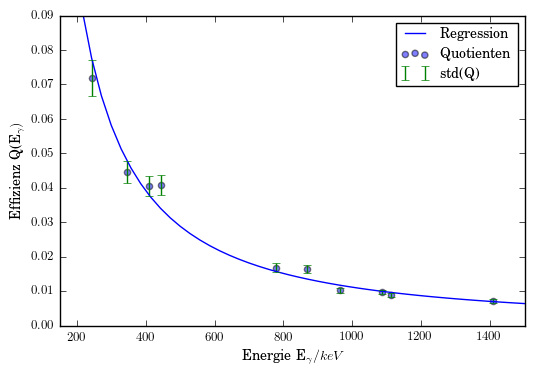

In [8]:
WWW = np.array([7.6, 26.5, 2.2, 3.1, 12.9, 4.2, 14.6, 10.2, 13.6, 21.0])/100 #Wechselwirkungswahrscheinlichkeit
lifetime = 3172 # Zeit in der Effekttiv ein Signal gemessen werden konnte
Q = EU.peak[1,1:]*4*np.pi/(Raumwinkel*AktEu*WWW*lifetime) #Effizienz
def pot(x,a, b):
    return a*(x)**(b)
print('Effizienz', Q)
paramsEffi = unumpy.uarray([params[0], params[1]],[std[0],std[1]])
params, cov = curve_fit(pot,unumpy.nominal_values(EU.peak[0,1:]), unumpy.nominal_values(Q), sigma=unumpy.std_devs(Q))
std = np.sqrt(np.diag(cov))
print("Fitparameter: a = ",paramsEffi[0] ,"b =", paramsEffi[1])
x = np.linspace(100,1500)
plt.plot(x, pot(x, *params), label='Regression')
plt.scatter(unumpy.nominal_values(EU.peak[0,1:]),un.nominal_values(Q), label='Quotienten', alpha=0.5)
plt.errorbar(unumpy.nominal_values(EU.peak[0,1:]),un.nominal_values(Q),yerr=unumpy.std_devs(Q), linestyle="None", label="std(Q)")
plt.xlabel(r"Energie E_\gamma / keV")
plt.ylabel(r"Effizienz Q(E_\gamma)")
plt.xlim(150,1500)
plt.ylim(0,0.09)
plt.legend(loc='best')
plt.savefig('./build/Effizienz.pdf')
plt.show()

# Cäsium
- Experimentell bestimmte Gamma Energie  $E_\gamma = 663.36 keV$ 
    - theo : $662 keV$
    - Natürliche Energie $\epsilon = \frac{E_\gamma}{m_0 c^2} = 1.2982$
- Experimentell bestimmter Rückstreupeak  $E_{Rück} = 470 keV$ 
    - theo : $E_\text{e,max} = E_\gamma \frac{2 \epsilon}{1 + 2 \epsilon} = E_\gamma 0.7219 = 478.87 keV $
- Auflösngsvermögen des Detektors
    - $\Delta E_{1/2}(663 keV) = 2.35 \sqrt{0.1 E_\gamma E_{EL}} = 1.03 keV$ 
    - Experimentell ermittelter $ = 1.46 keV $
        - Endliche Anzahl an Kanälen
        - Detektorbereich optimieren
    - Fehler Halbwertsbreite ~ 10-Wertsbreite = 2%

In [15]:
CS = makeSpek(Cs, scale=scaleing)
CS.stdGaus()
print(CS.peak)
CS.corPeak(CS.peak[:,0])
# print(np.sqrt(2*np.pi)*(unumpy.std_devs(CS.peak)[0])*CS.peak[1])

FUUUUUUUUUUUUUUUUUU [663.3663071223571+/-0.6036504576475539]
FUUUUUUUUUUUUUUUUUU [1462.414200430777+/-0.5470506780866115]
[[663.3663071223571+/-0.6036504576475539
  1462.414200430777+/-0.5470506780866115]
 [2118.0+/-0 8.0+/-0]]


Energie =  [663.3663071223571+/-0 2118.0+/-0]


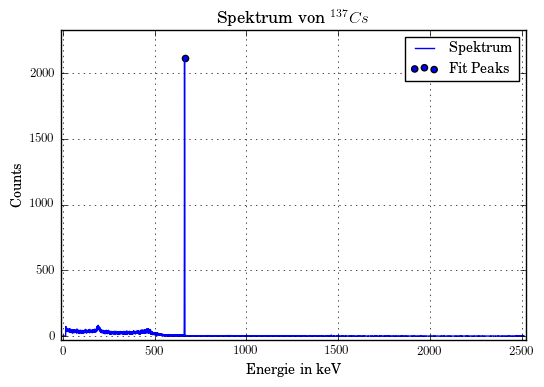

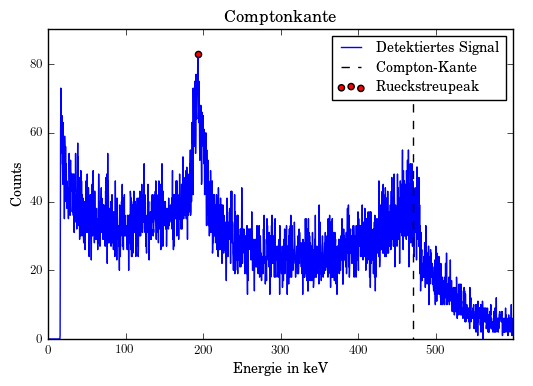

In [10]:
CS = makeSpek(Cs, scale=scaleing)
CS.corPeak(CS.peak[:,0])
print('Energie = ',CS.peak)
CS.plot(title="^{137}Cs",pathToSave="CS")
CS.plotSector(smin=0,smax=600,title="Comptonkante", show=False)
plt.scatter(193,83,c='r', label='Rueckstreupeak')
plt.plot((470,470),(88,0),'k--', label='Compton-Kante')
plt.legend(loc='best')
plt.savefig("./build/Compton.pdf")
plt.show()

Die 10 Wertsbreite beträgt :  [ 2.59913275]


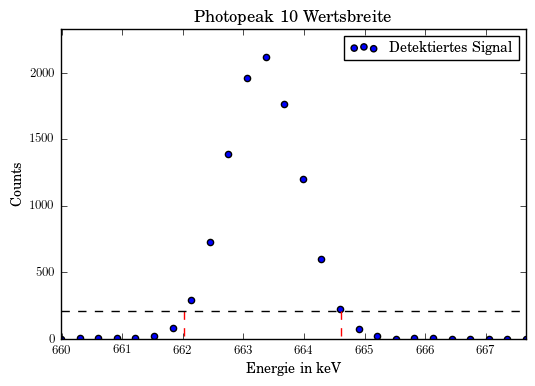

Die 2 Wertsbreite beträgt :  [ 1.45618095]


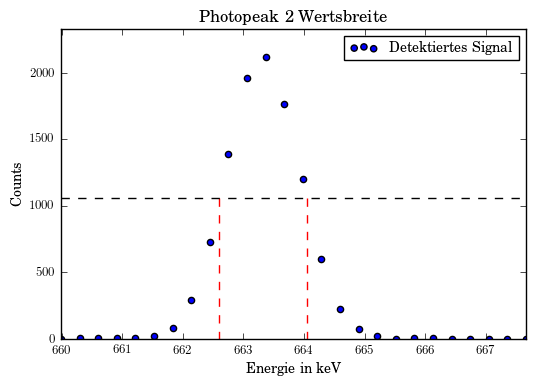

Verhältniss der beiden Breite [ 1.78489682]


In [11]:
a = CS.percentWidth(width=10,smin=660,smax=668, title="Photopeak 10 Wertsbreite",pathToSave="10", plotStyle=plt.scatter)
b = CS.percentWidth(width=2,smin=660,smax=668, title="Photopeak 2 Wertsbreite",pathToSave="2", plotStyle=plt.scatter)
print('Verhältniss der beiden Breite', a/b)

- Länge des Detektorchristall = 3.85 cm 
- Germanium
    - Dichte 5323 $kg/m^3$
    - z Kernladungszahl = 32
    - A Atomgewicht = 72.63 u (u = 1.66E^-27kg)
    - $N_L = 2.68E(25)$
    - $\sigma_{Photo}(600 keV) = 0.01$
    - $\sigma_{Compton}(600 keV) = 0.04$
- $\mu = n \sigma = \frac{z N_L \rho}{A} \sigma = 319$
- $N(D) = N_0 e^{-\mu D} = N_0 * 4.636E-6  $

In [12]:
print(sum(CS.data[:2180])/2740)

23.9343065693


# Aktivitätsbestimmung Barium
- Intensitäten = Zählergebniss

[[82.0+/-0.41957976973415423 162.6951146574962+/-2.567089017452299
  304.82311104696925+/-0.4596178950838214
  357.9292522464916+/-0.4921614725333568 386.0+/-0.5216860221463843]
 [3177 144.0+/-0 918.0+/-0 2509.0+/-0 320]]


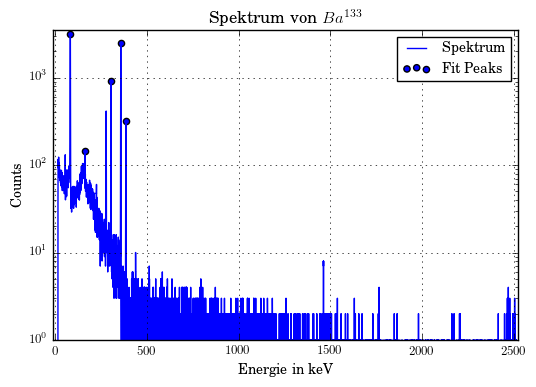

[10710.076132178903+/-578.6303409165847
 2198.3193188395544+/-385.73511483264053
 3553.235907769151+/-64.28303115044648
 10117.723240446066+/-76.36765892582865
 1392.4642078884526+/-25.364035396924347]


In [29]:
BA = makeSpek(Ba, scale=scaleing)
BA.corPeak(BA.peak[:,1:-1])
BA.corPeak(np.append(BA.peak, np.array([[386],[320]]), axis=1))
BA.corPeak(np.append(BA.peak[:,1:], np.array([[82],[3177]]), axis=1))
BA.stdGaus()
BA.plot('Ba','Ba^{133}','log')
print(BA.hits)

In [38]:
baW = np.array([34.1, 0.6, 18.3, 62.1, 8.9])/100 #Emmisionewahrscheinlichkeit der Spektralline
baQ = pot(BA.peak[0,:], *paramsEffi) # Effizienz bei den entsprechenden Energien
# print(baQ)
BA.stdGaus(False)
print("Peaks: ",BA.peak[1])
lifetime = 3595
baA = BA.peak[1,:]*4*np.pi/(Raumwinkel*baW*baQ*lifetime)# Aktivität der verwendeten Bariumquelle
for x in range(len(BA.peak[1,:])):
    print(x, ': Intensitäten: ', BA.hits[x], "    Energie: ", BA.peak[0,x], "     Aktivität:", baA[x])
baA = np.append(baA[0],baA[2:]) #Wert 2 wird vernachlässigt weil er viel zu Groß ausfällt
print('Gemittelte Aktivität', np.mean(baA))

Peaks:  [3177 144.0+/-0 918.0+/-0 2509.0+/-0 320]
0 : Intensitäten:  (1.07+/-0.06)e+04     Energie:  82.0+/-0.4      Aktivität: (2.3+/-0.7)e+06
1 : Intensitäten:  (2.2+/-0.4)e+03     Energie:  162.7+/-2.6      Aktivität: (2.2+/-0.8)e+07
2 : Intensitäten:  (3.55+/-0.06)e+03     Energie:  304.8+/-0.5      Aktivität: (1.5+/-0.6)e+07
3 : Intensitäten:  (1.012+/-0.008)e+04     Energie:  357.9+/-0.5      Aktivität: (1.6+/-0.7)e+07
4 : Intensitäten:  1392+/-25     Energie:  386.0+/-0.5      Aktivität: (1.7+/-0.7)e+07
Gemittelte Aktivität (1.3+/-0.5)e+07


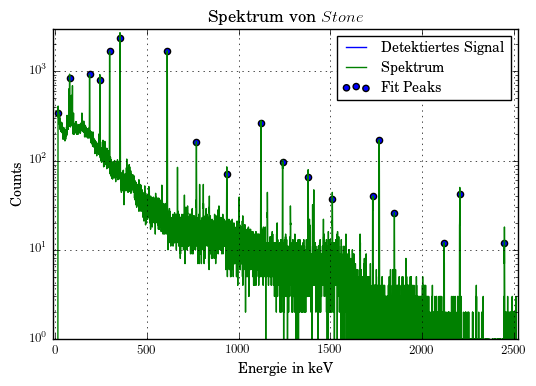

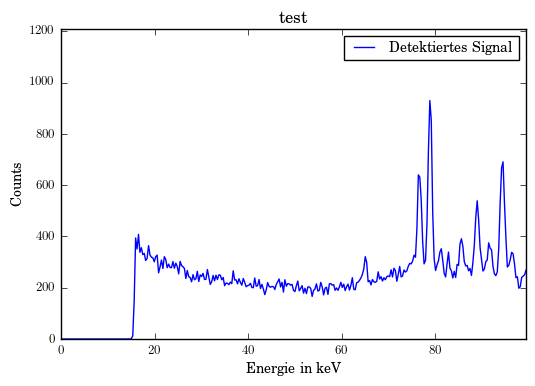

[16.88345529464583+/-0 79.19875392761135+/-0 187.8668116422409+/-0
 244.04267198624427+/-0 297.14881318576664+/-0 353.93861735866625+/-0
 611.181081666179+/-0 770.1925333502979+/-0 935.9573671522752+/-0
 1122.2893192222755+/-0 1240.1665343703482+/-0 1379.5317835297883+/-0
 1511.222734828026+/-0 1731.628569401766+/-0 1766.316395734402+/-0
 1849.1988126353906+/-0 2120.5619850075163+/-0 2205.90017722409+/-0
 2449.328905381438+/-0]


In [40]:
ST = makeSpek(St, scale=scaleing)
ST.plot('St','Stone','log')
ST.plotSector(0,100)
print(ST.peak[0,:])